<a href="https://www.kaggle.com/erfansobhaei/persainpoemclassifier?scriptVersionId=86050758" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Installing and Importing

In [95]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import wandb

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from transformers import TrainingArguments, Trainer

In [96]:
!pip install -q gdown
!gdown --id --folder 1cmrCgvpowRN4ySol4J8ZT0oVh_0v75Q_

Retrieving folder list
Retrieving folder 1BofFHgAzps0hcdbKnR6vNmj7_hlw0cKU org
Processing file 1XmfqB3ZPw8W6jicmHVtkPRekf9ze2snR poetry_rumi.txt
Processing file 11mlHdcZZJTjGcPvB7hio91D_OjB0MQRc poetry_saadi.txt
Retrieving folder 1dOatmQ0CrMEN4lmWl9Pt7v7Ts0dm7W6p small
Processing file 1nXY_40w8GHVx3ujfjBPNYFChww7Jhcvm poetry_rumi.txt
Processing file 1K-IzTHCR5u_EUm_ZXSrdR6a02qLLD-hg poetry_saadi.txt
Retrieving folder list completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1XmfqB3ZPw8W6jicmHVtkPRekf9ze2snR
To: /kaggle/working/dataset/org/poetry_rumi.txt
100%|████████████████████████████████████████| 194k/194k [00:00<00:00, 81.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=11mlHdcZZJTjGcPvB7hio91D_OjB0MQRc
To: /kaggle/working/dataset/org/poetry_saadi.txt
100%|████████████████████████████████████████| 110k/110k [00:00<00:00, 74.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1nXY_40w8GHVx

# Small Dataset Classification

## Understanding Dataset 

In [97]:
def read_file(path, label):
    df = pd.read_csv(path, delimiter = "\n", names=["text", 'label'])
    df['label'] = label
    return df

In [98]:
df_rumi_small = read_file('./dataset/small/poetry_rumi.txt', 'Rumi')
df_saadi_small = read_file('./dataset/small/poetry_saadi.txt', 'Saadi')

df_small = pd.concat([df_rumi_small, df_saadi_small], ignore_index=True)
df = df_small.sample(frac=1).reset_index(drop=True)
df.head()

,text,label
0,روزی تر و خشک من بسوزد,Saadi
1,تو دوستی کن و از دیده مفکنم زنهار,Saadi
2,چنان به ذوق ارادت خورم که حلوا را,Saadi
3,کسی که خورده بود می ز بامداد الست,Saadi
4,صوفی گران جانی ببر ساقی بیاور جام را,Saadi


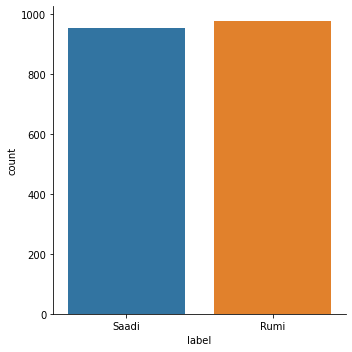

In [99]:
sns.catplot(data=df, x='label', kind='count')
plt.show()

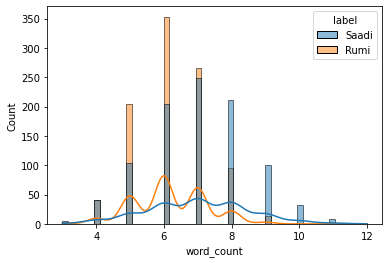

In [100]:
df['word_count'] = df['text'].str.count(' ') + 1

sns.histplot(data=df, x='word_count', hue='label', kde=True)
plt.show()

# Using Transformer Models

## BERT

### Loading Pretrained Model

In [101]:
from transformers import BertForSequenceClassification, BertTokenizer

In [102]:
model_name = "bert-base-multilingual-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

loading file https://huggingface.co/bert-base-multilingual-uncased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/269f2943d168a4cd2ddf3864cee89d7f7d78873b3d14a1229174d37212981a38.92022aa29ab6663b0b4254744f28ab43e6adf4deebe0f26651e6c61f28f69d8b
loading file https://huggingface.co/bert-base-multilingual-uncased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/bert-base-multilingual-uncased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/bert-base-multilingual-uncased/resolve/main/tokenizer_config.json from cache at /root/.cache/huggingface/transformers/1b935b135ddb021a7d836c00f5702b80d11d348fd5c5a42cbd933d8ed1f55be9.20430bd8e10ef77a7d2977accefe796051e01bc2fc4aa146bc862997a1a15e79
loading file https://huggingface.co/bert-base-multilingual-uncased/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/857db185d48b92f3e6141ef5092d8d5dbebab7eef1bacc6c9eaf85cf2

### Preprocess Data

In [103]:
df['label'] = pd.factorize(df['label'])[0]

X = list(df['text'])
y = list(df['label'])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=256)
X_val_tokenized = tokenizer(X_val, padding=True, truncation=True, max_length=256)

In [104]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, label=None):
        self.encodings = encodings
        self.label = label

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.label:
            item["label"] = torch.tensor(self.label[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

train_dataset = Dataset(X_train_tokenized, y_train)
val_dataset = Dataset(X_val_tokenized, y_val)

### Train Model

In [105]:
def compute_metrics(p):
    preds, labels = p
    preds = np.argmax(preds, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=preds)
    f1 = f1_score(y_true=labels, y_pred=preds)

    return {"accuracy":accuracy, "f1": f1}

In [106]:
args = TrainingArguments(
    output_dir="output",
    run_name="BERT Model",
    evaluation_strategy="epoch",
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=5,
    logging_steps = 10,
    seed=0,
)
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 1544
  Num Epochs = 5
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 125
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.580500,0.424731,0.841969,0.828169
2,0.317000,0.277285,0.906736,0.905759
3,0.195400,0.288234,0.891192,0.879310
4,0.108600,0.255678,0.911917,0.909574
5,0.052900,0.241684,0.932642,0.931217


***** Running Evaluation *****
  Num examples = 386
  Batch size = 64
***** Running Evaluation *****
  Num examples = 386
  Batch size = 64
***** Running Evaluation *****
  Num examples = 386
  Batch size = 64
***** Running Evaluation *****
  Num examples = 386
  Batch size = 64
***** Running Evaluation *****
  Num examples = 386
  Batch size = 64


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=125, training_loss=0.2875684959888458, metrics={'train_runtime': 23.5892, 'train_samples_per_second': 327.268, 'train_steps_per_second': 5.299, 'total_flos': 79344427632000.0, 'train_loss': 0.2875684959888458, 'epoch': 5.0})

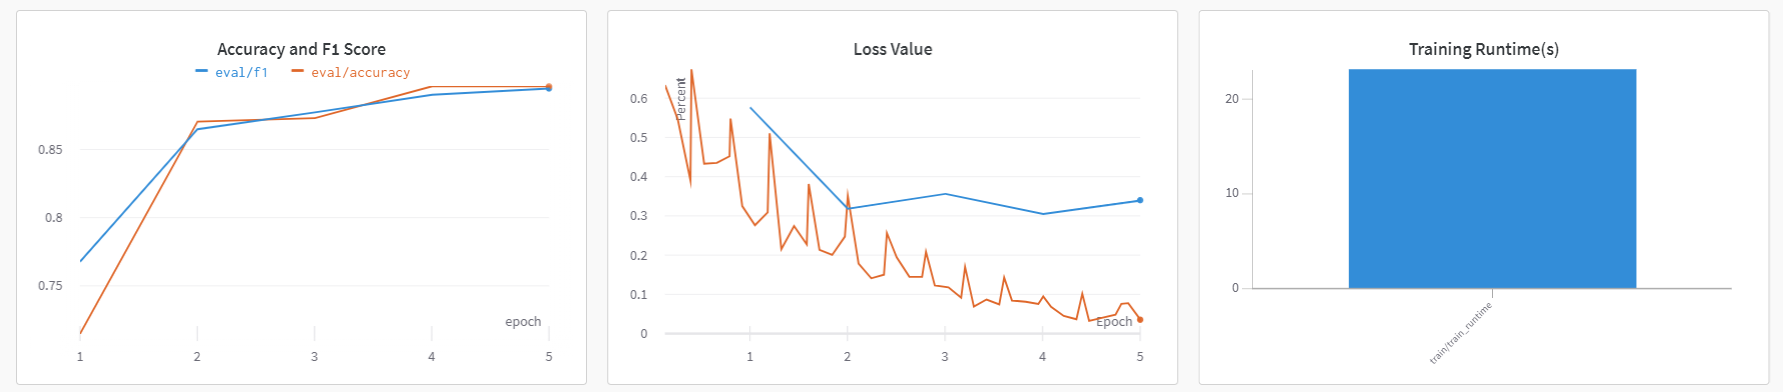

## RoBERTa

### Loading Pretrained Model

In [107]:
from transformers import XLMRobertaForSequenceClassification, XLMRobertaTokenizer

In [108]:
model_name = "xlm-roberta-base"
tokenizer = XLMRobertaTokenizer.from_pretrained(model_name)
model = XLMRobertaForSequenceClassification.from_pretrained(model_name, num_labels=2)

loading file https://huggingface.co/xlm-roberta-base/resolve/main/sentencepiece.bpe.model from cache at /root/.cache/huggingface/transformers/9df9ae4442348b73950203b63d1b8ed2d18eba68921872aee0c3a9d05b9673c6.00628a9eeb8baf4080d44a0abe9fe8057893de20c7cb6e6423cddbf452f7d4d8
loading file https://huggingface.co/xlm-roberta-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/xlm-roberta-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/xlm-roberta-base/resolve/main/tokenizer_config.json from cache at None
loading file https://huggingface.co/xlm-roberta-base/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/daeda8d936162ca65fe6dd158ecce1d8cb56c17d89b78ab86be1558eaef1d76a.a984cf52fc87644bd4a2165f1e07e0ac880272c1e82d648b4674907056912bd7
loading configuration file https://huggingface.co/xlm-roberta-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/87

### Preprocess Data

In [109]:
X = list(df['text'])
y = list(df['label'])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=128)
X_val_tokenized = tokenizer(X_val, padding=True, truncation=True, max_length=128)

In [110]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, label=None):
        self.encodings = encodings
        self.label = label

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.label:
            item["label"] = torch.tensor(self.label[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

train_dataset = Dataset(X_train_tokenized, y_train)
val_dataset = Dataset(X_val_tokenized, y_val)

In [111]:
args = TrainingArguments(
    output_dir="output",
    run_name="XLMRoBERTa Model",
    evaluation_strategy="epoch",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    logging_steps =10,
    seed=0,
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 1544
  Num Epochs = 5
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 245
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.663300,0.520311,0.751295,0.680000
2,0.397000,0.360697,0.844560,0.837838
3,0.261200,0.358795,0.862694,0.850704
4,0.255400,0.325711,0.854922,0.840000
5,0.132800,0.376581,0.873057,0.857971


***** Running Evaluation *****
  Num examples = 386
  Batch size = 32
***** Running Evaluation *****
  Num examples = 386
  Batch size = 32
***** Running Evaluation *****
  Num examples = 386
  Batch size = 32
***** Running Evaluation *****
  Num examples = 386
  Batch size = 32
***** Running Evaluation *****
  Num examples = 386
  Batch size = 32


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=245, training_loss=0.3573850395728131, metrics={'train_runtime': 36.3302, 'train_samples_per_second': 212.495, 'train_steps_per_second': 6.744, 'total_flos': 71409984868800.0, 'train_loss': 0.3573850395728131, 'epoch': 5.0})

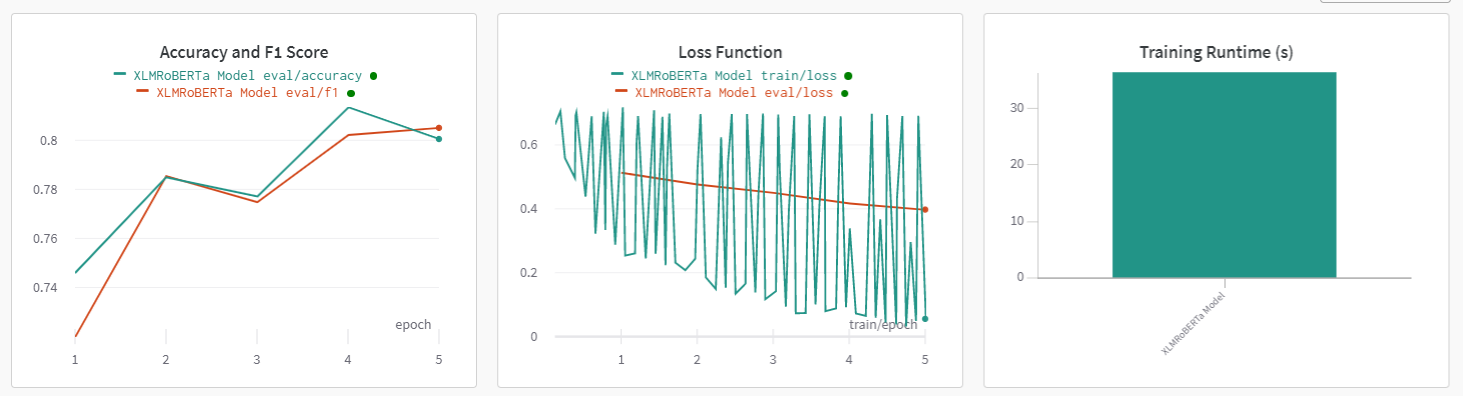